<a href="https://colab.research.google.com/github/neel26desai/deep_learing_with_low_code_libraries/blob/main/keras%2Bcv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

# Using YOLO for Object detection

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

In [ ]:
#let us look at the image that we are trying to perform object detection one

filepath='/content/drive/MyDrive/data/object_detection_generated_by_dalle.jpg'
image = keras.utils.load_img(filepath)
#converting the image to numpy array
image = np.array(image)
print(image.shape)

#displaying the image
visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    scale=5,
)

In [ ]:
# we plan on using YOLOv8 with ResNet backbone for object detection
# on of the requirement for the model is that the image size should be divisible by 64
# we saw earlier our image size is 1240 by 1249
image.shape[0]/64,image.shape[1]/64

In [ ]:
#resizing the image to make it quicker for prediction  purpose
resizing_layer = keras_cv.layers.Resizing(640,640, bounding_box_format="xywh", pad_to_aspect_ratio=True )
#applying the resizing layer to our image
resized_image = resizing_layer([image])

In [ ]:
resized_image.shape

In [ ]:
resized_image[0].shape

In [ ]:
#initializing the YOLOv8 mode
yolo =  keras_cv.models.YOLOV8Detector.from_preset("yolo_v8_m_pascalvoc", bounding_box_format="xywh")

In [ ]:
#using the model to make the prediction
preds = yolo.predict(resized_image)

In [ ]:
preds.keys()

In [ ]:
yolo.input_shape

In [ ]:
#the model return the bounding boxes, confidence, classes and number of times the objects were detected
#let us look at the classes
preds['classes']

In [ ]:
#the classes are integer values we need to , to do a mapping from integer value to actual label
#this class_id to label mapping is different for every model, four our mode it is this based on https://keras.io/guides/keras_cv/object_detection_keras_cv/
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
#mapping integers to values
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [ ]:
visualization.plot_bounding_box_gallery(
    resized_image,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=preds,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

# Classification with Keras- CV

In [ ]:
import os
#using tensorflow backend
os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics

import keras_cv

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds


## Using pretrained classifier for inference

In [ ]:
#using efficientnetv2_b0_imagenet_classifier pretrained backed
classifier = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet_classifier"
)

In [ ]:
filepath = '/content/drive/MyDrive/data/horse.jpeg'
image = keras.utils.load_img(filepath)
#convert the image to numpy array
horse_image = np.array(image)
#printing out the image
keras_cv.visualization.plot_image_gallery(
    np.array([image]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4
)

In [ ]:
image.shape

In [ ]:
np.expand_dims(image, axis=0).shape

In [ ]:
#making prediction, before we ccan make a prediction, we need to add another dimension to the image array, that will represent the number of images in a batch prediction
predictions = classifier.predict(np.expand_dims(image, axis=0))


In [ ]:
#the prediction is give in a softmax fashion, where we have the probability of the image belonging to each of the class for which the model was trained
predictions.shape# the efficientnetv2_b0_imagenet_classifier was trainned on 1000 classes

In [ ]:
predictions[0][1]

In [ ]:
#sorting the prediction index values, in the decresing order of the probability value, argsort returns the index values neede to sort the array
top_classes = predictions[0].argsort(axis=-1)#axis-1 is the last axis,


In [ ]:
top_classes[:2]

In [ ]:
#downloading the encoding of index to classes
classes = keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)
with open(classes, "rb") as f:
    classes = json.load(f)

In [ ]:
top_two = [classes[str(i)] for i in top_classes[-2:]]
print("Top two classes are:", top_two)

In [ ]:
filepath = '/content/drive/MyDrive/data/human.jpeg'
image = keras.utils.load_img(filepath)
#convert the image to numpy array
human_image = np.array(image)
#printing out the image
keras_cv.visualization.plot_image_gallery(
    np.array([human_image]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4
)

In [ ]:
predictions = classifier.predict(np.expand_dims(image, axis=0))

In [ ]:
top_classes = predictions[0].argsort(axis=-1)

In [ ]:
top_two = [classes[str(i)] for i in top_classes[-2:]]
print("Top two classes are:", top_two)

This is what we were looking for. Even though the model was'nt able to identify human and horse it is okay, this is cause the model wasn't trained to recognize them. So what were looking for is that it classifies the images close to the actual lable. And from there we can fine tune the model on our dataset so that it can correctly idetify horses and humans.


#Fine tuning a Pretrained BackBone

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
#tfds.disable_progress_bar()

#getting the cats_vs_dogs dataset
data, dataset_info = tfds.load("horses_or_humans", with_info=True, as_supervised=True)
#
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

#getting the number of classes
num_classes = dataset_info.features["label"].num_classes

#creating a resizzing object to recixe all images to 224, 224
resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    # cas allt numpy variable to tf.float32
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

In [ ]:
model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

In [ ]:
history= model.fit(train_dataset,epochs=5)


In [ ]:
predictions = model.predict(np.expand_dims(human_image, axis=0))

classes = {0: "horse", 1: "human"}
print("Top class is:", classes[predictions[0].argmax()])

In [ ]:
predictions = model.predict(np.expand_dims(horse_image, axis=0))
print("Top class is:", classes[predictions[0].argmax()])

#Building an Image Classifier from scratch

As we did above we will be building an image classifier capable of differentiating humans from horses.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import keras_cv
import matplotlib.pyplot as plt
import keras

In [ ]:
#using tensorlfow backend
os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

In [ ]:
# Load the Horse or Human dataset
(train_ds, val_ds), dataset_info = tfds.load('horses_or_humans',split=['train', 'test'],
                                              as_supervised=True,
                                              with_info=True
                                                            )


In [ ]:
# Function for preprocessing images
def preprocess_image(image, label):
    #reshaping the image to 224 by 224 size and then normalizing the pixel values
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    return image, label

# setting mapping preproccesing functions to our input, it will be applied in a lazzy manner
train_ds = train_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Build a simple CNN model using keras_cv layers
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model, the lazy preprocessing steps will be applied at this step
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

In [ ]:
# Visualize the training and validation accuracy and loss, at different epochs for the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Building our own Image Classifier by adding layers to a pretrained model

In [ ]:
#getting the pretrained backbone, (note here the pretrained model and the model we build earlier both have the same required input shape of 224,224,3)
backbone = keras_cv.models.EfficientNetV2B0Backbone()
#adding additional layers to the pretrained backbone
model2 = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [ ]:
# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history2 = model2.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

In [ ]:
# Visualize the training and validation accuracy and loss
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

For the Image classification when we build model from scartch we got an accuracy of 79% on the test set, and when we used added a extra layers (dropout layer was added) we got an ccuract of of 75%, this make sense as instead of adding capacilities to the pretrained model we added a dropout layer with 50% connection drop.

# Training a Custom Object Detection Model

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import tensorflow as tf
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

In [3]:
#defining the Bath
BATCH_SIZE = 4

In [4]:
#class mapping for pascal voc/2007
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
#create a mapping that maps the elements in the above list to numeric values
# we need the numeric values to allow the model to predict
class_mapping = dict(zip(range(len(class_ids)), class_ids))



In [5]:
#defining the usefull functions for  visualization
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    """
    Visualizes a batch of images from a TensorFlow dataset along with their associated bounding boxes.

    Parameters:
    - inputs (tf.data.Dataset): A TensorFlow dataset containing images and bounding boxes.
    - value_range (tuple): The range of pixel values in the images (e.g., [0, 255]).
    - rows (int): Number of rows in the image gallery.
    - cols (int): Number of columns in the image gallery.
    - bounding_box_format (str): Format of the bounding boxes (e.g., 'xywh', 'xyxy').

    Note: The function assumes that the dataset `inputs` has a batch size of at least 1 and that
    each element in the dataset is a dictionary with keys "images" and "bounding_boxes".
    """
    # Take one batch from the dataset.
    inputs = next(iter(inputs.take(1)))

    # Extract images and bounding boxes from the batch.
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]

    # Plot a gallery of images with bounding boxes.
    visualization.plot_bounding_box_gallery(
        images,                                  # The images to display.
        value_range=value_range,                 # The range of pixel values.
        rows=rows,                               # Number of rows in the gallery.
        cols=cols,                               # Number of columns in the gallery.
        y_true=bounding_boxes,                   # Ground truth bounding boxes for the images.
        scale=5,                                 # Scaling factor for the size of the gallery.
        font_scale=0.7,                          # Scale for the font used in annotations.
        bounding_box_format=bounding_box_format, # Format of the bounding boxes.
        class_mapping=class_mapping,             # Mapping of class IDs to class names.
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    """
    Unpacks and converts the bounding box format of inputs from a raw TensorFlow dataset.

    Parameters:
    - inputs (dict): A dictionary containing raw inputs from a TensorFlow dataset. It is expected
      to have an "image" key with image data, and an "objects" key with a sub-dictionary containing
      "bbox" (bounding box coordinates) and "label" (class labels).
    - bounding_box_format (str): The target format for the bounding boxes (e.g., 'xywh', 'xyxy').

    Returns:
    - dict: A dictionary with keys "images" and "bounding_boxes". The "images" key contains the image
      data, and the "bounding_boxes" key contains a dictionary with "classes" and "boxes" keys, where
      "classes" are the class labels and "boxes" are the bounding boxes in the target format.
    """
    # Extract the image from the inputs.
    image = inputs["image"]
    # Print the original bounding box format.
    print("Original bounding box format (rel_yxyx):", inputs["objects"]["bbox"])
    # Convert the bounding box format from relative coordinates (rel_yxyx) to the target format.
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    print('Adding labels')
    # Package the bounding boxes with their class labels.
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }

    # Return the processed inputs.
    return {"images": image, "bounding_boxes": bounding_boxes}


In [6]:
#functions for koading the data
def load_pascal_voc(split, dataset, bounding_box_format):
    '''
    Loads the PASCAL VOC dataset with the specified split and bounding box format.
    '''
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    # creating a lazy execution that converts the bounding box format to our desire format
    # and to get the data in the required format
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds

#loading the train split of the pascal voc/2007 dataset
train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
#loading the test split of the pascal voc/2007 dataset
test_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

#shuffling the dataset so that the model doesn't learn anyy unintend patter , due to the order of the images
#train_ds = train_ds.shuffle(BATCH_SIZE * 4)
# batching the trained df, using ragged to allow different tensor shapes across images
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

Original bounding box format (rel_yxyx): Tensor("args_4:0", shape=(None, 4), dtype=float32)
Adding labels
Original bounding box format (rel_yxyx): Tensor("args_4:0", shape=(None, 4), dtype=float32)
Adding labels


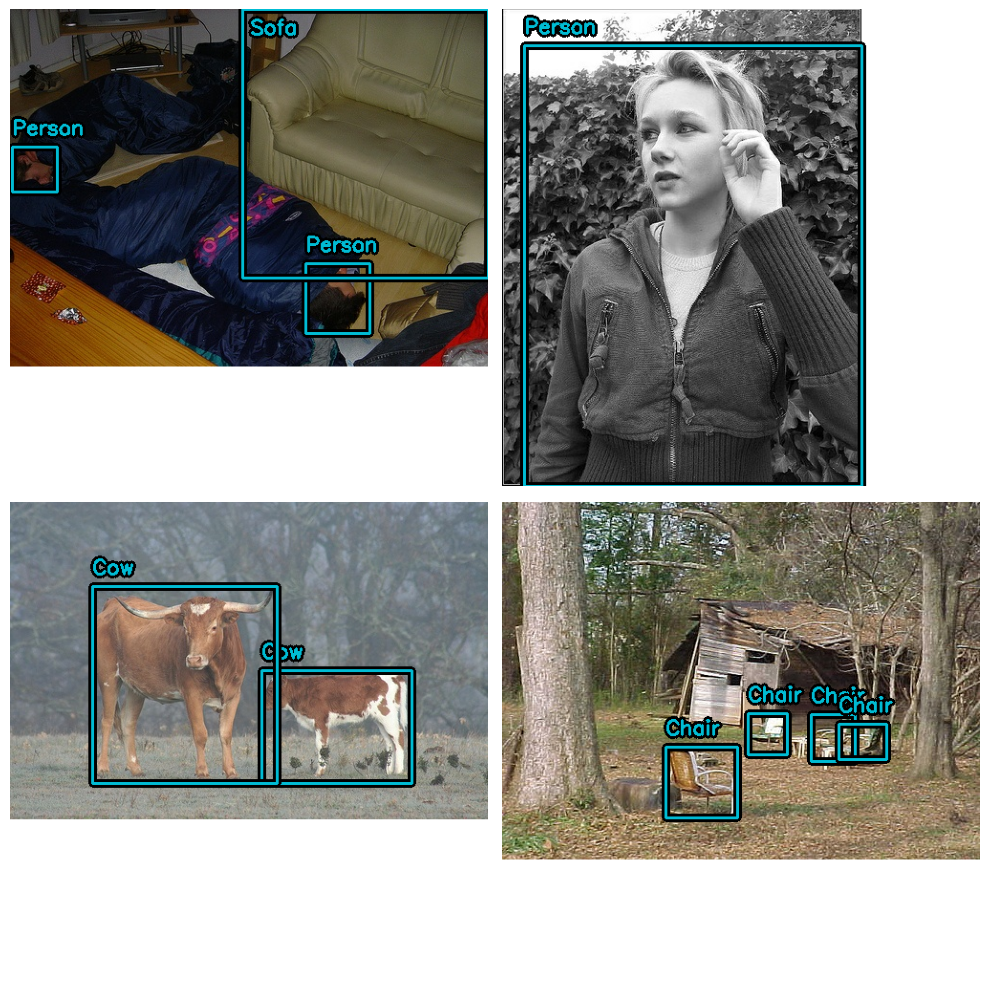

In [7]:
#visualizing a a single batch from the train split
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

## Data Augmentation

For each of the image in the train set we will perform 2 data augmentation on them. Firstly we will horizonatally flip the image the image and the we perferorm a jitter resizing operation, and resize the images of 640 by 640

In [8]:
#defining the list of augmentations that we need to perform
augmenters = [

    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]

#creating a function that takes the list of augmenters apply them to image and r
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)


In [9]:
#TODO: Visualize how we can apply data augmentation is affecting the image

# # Take one example from the original dataset
# for example in train_ds.take(1):
#     original_image = example["images"]
#     original_bounding_boxes = example["bounding_boxes"]
#     break
# augmented_example = augmenter_fn(example)
# augmented_image = augmented_example["images"]
# augmented_bounding_boxes = augmented_example["bounding_boxes"]
# import matplotlib.pyplot as plt

# # Visualize the original image
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# visualize_single_image(original_image, original_bounding_boxes, bounding_box_format="xywh")

# # Visualize the augmented image
# plt.subplot(1, 2, 2)
# plt.title("Augmented Image")
# visualize_single_image(augmented_image, augmented_bounding_boxes, bounding_box_format="xywh")

# plt.show()


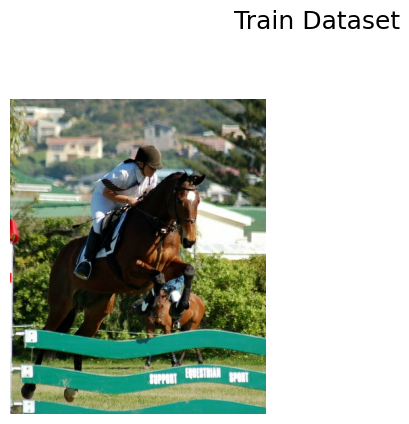

In [10]:
#visualizing the
from matplotlib import pyplot as plt
def visualize_dataset2(dataset, title):
    plt.figure(figsize=(9, 9)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(1))):
        images = samples["images"]
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

visualize_dataset2(train_ds, "Train Dataset")

In [11]:
#apply the agumentation, to the entire train set
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)

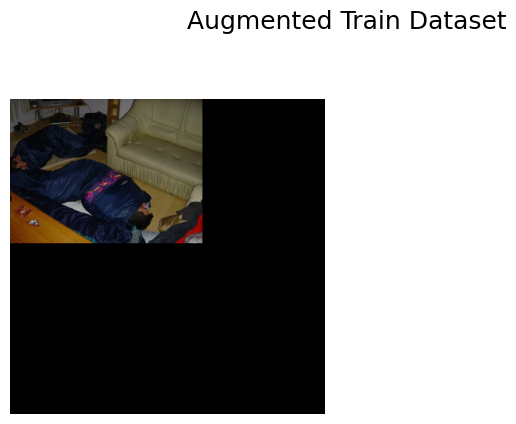

In [12]:
#visualizing the augmented trainset
visualize_dataset2(train_ds, "Augmented Train Dataset")

In [13]:
#for sake of keeping the images uniform, we will be applying the resizing layer to our test dataset as well
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
test_ds = test_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

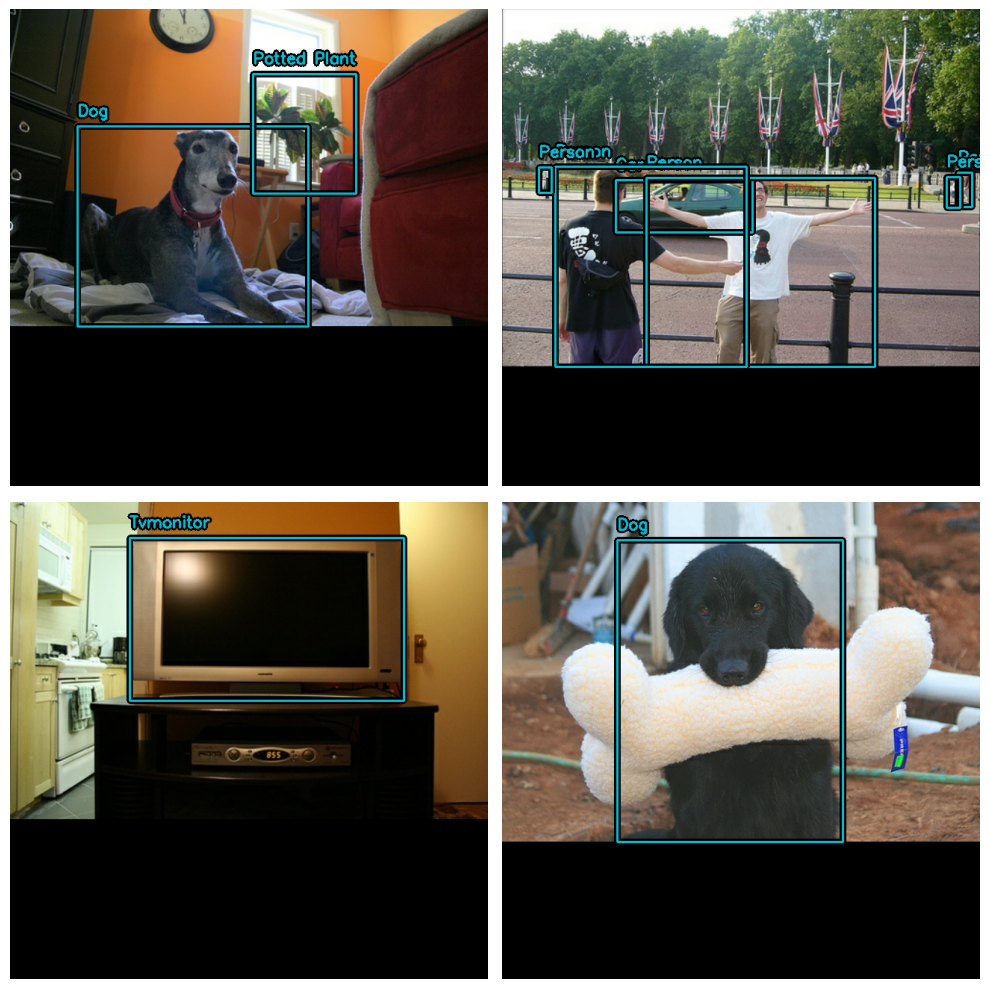

In [14]:
visualize_dataset(
    test_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [15]:
# processing the inputs anc converting them to tupplied
def dict_to_tuple(inputs):
    #converting the bounding boxes from
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

#mapping the the aboce transformation to be applied to train and test set
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
# enabling prefatching another batch when current is being processed for both train and test set
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

In [16]:
#declaring an SGD optimizer
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [17]:
# we are using NonMaxSuppression to reduce probability of having overlapping bounding boxes
#the prediction encorder layer is the layer that works after the raw model predictions
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.7,
)

## Model Creation

In [18]:
# Load the base YOLOv8 model
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    bounding_box_format="xywh",
    num_classes=len(class_mapping),
)
# Compile the new model


In [27]:
#compiling our model, we need to specify 2 loss functions one for the correct object detection and other for bounding box predictions
#ciou - is complete intersection over union loss

model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

In [28]:
#calulating the coco_metrics_callback on first 10 batches of test_ds at the end of each epoch
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    test_ds.take(10), bounding_box_format="xywh"
)

In [29]:
# Train the new model on first 10 epochs of
model.fit(
    train_ds.take(20),
    epochs=2,
    callbacks=[coco_metrics_callback],
)


Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 389ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -

In [30]:
visualization_ds = test_ds.unbatch()#unbatching the test dataset
visualization_ds = visualization_ds.ragged_batch(16) # creating ragged batches with 16 elements per bacth
visualization_ds = visualization_ds.shuffle(8)#creating a shuffle in the dataset with 8

In [23]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    #take the first batch on the dataset , use it for making the predictio and then plot the predictions
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 64s 64s/step


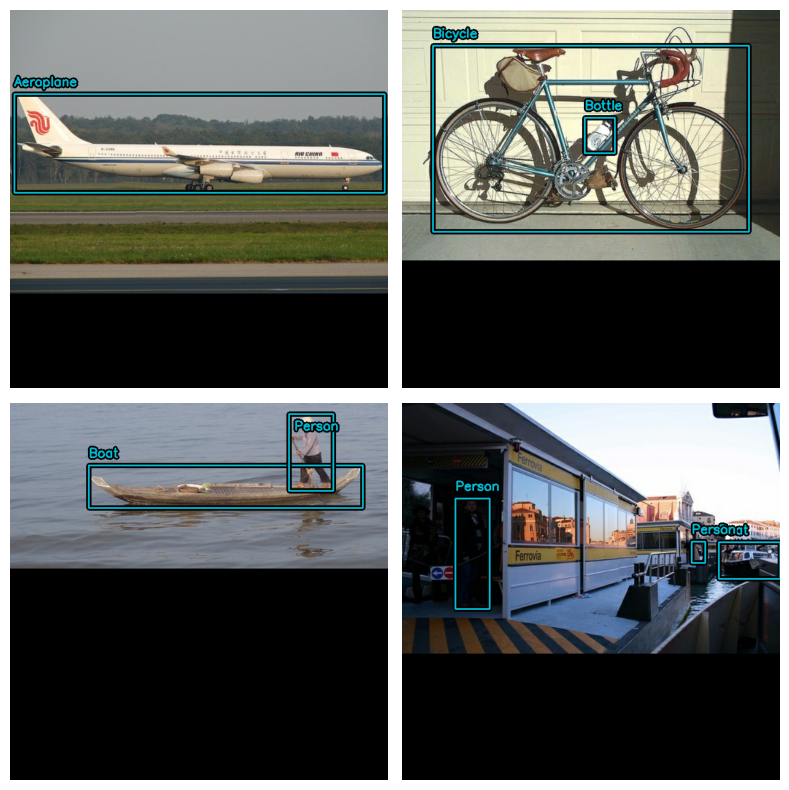

In [31]:
#the model outputs in raw format which we need to convert in a format such that , we eliminates overlapping bounding boxes
#for hthis we use a NoMaxSuppresion layer, the prediction decoder layer is the layer that works after the raw model predictions
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

#Reference:
1. https://keras.io/guides/keras_cv/object_detection_keras_cv/
2. https://keras.io/guides/keras_cv/classification_with_keras_cv/